## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import os
import random
import json

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Precision, Recall, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from keras.applications import VGG16, ResNet50
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Activation, GaussianNoise
from keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, log_loss, roc_curve, auc
from keras.regularizers import l2
from glob import glob
from os import walk
from PIL import Image

%matplotlib inline

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


In [2]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        return true_positives / (possible_positives + K.epsilon())
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        return true_positives / (predicted_positives + K.epsilon())
    precision = precision(y_true, y_pred); recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
IMG_SIZE = (224, 224)

train_batch_size = 32
test_batch_size  = 512

input_shape = ((IMG_SIZE[0], IMG_SIZE[1], 3))

## Do some early processing of your metadata for easier model training:

In [4]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
28124,00007328_000.png,No Finding,0,7328,40,M,PA,2500,2048,0.168,0.168,NaN,/data/images_004/images/00007328_000.png
32314,00008464_002.png,Atelectasis,2,8464,53,F,PA,2048,2500,0.168,0.168,NaN,/data/images_004/images/00008464_002.png
31954,00008352_004.png,Effusion,4,8352,67,M,PA,2500,2048,0.168,0.168,NaN,/data/images_004/images/00008352_004.png


In [5]:
# Get rid of images with Patient Age > 100:
print(all_xray_df.loc[all_xray_df["Patient Age"]>100]["Patient Age"])
all_xray_df.drop(all_xray_df[all_xray_df["Patient Age"]>100].index, inplace=True)

20852     412
46965     414
48284     148
55742     148
58650     150
62929     149
74884     152
78795     151
84810     411
85404     412
86264     413
91369     412
95794     153
98495     154
101194    155
104590    155
Name: Patient Age, dtype: int64


In [6]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Disease labels
all_labels = set()
for index, row in all_xray_df["Finding Labels"].iteritems():
    for el in row.split('|'):
        all_labels.add(el)
        
# Add 0 / 1 columns with disease name:
for disease in all_labels:
    all_xray_df[disease] = np.where(all_xray_df["Finding Labels"].str.contains(disease), 1, 0)
all_xray_df.head()

all_xray_df["ap"] = np.where(all_xray_df["View Position"]=="AP", 1, 0)

In [7]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df["pneumonia_class"] = all_xray_df["Pneumonia"].map(lambda x: 'True' if x==1.0 else 'False')

In [8]:
all_xray_df.pneumonia_class.head()

0    False
1    False
2    False
3    False
4    False
Name: pneumonia_class, dtype: object

## Create your training and testing data:

In [9]:
# Print and return some stats about a DataFrame
def stats_data(data):
    n = len(data.index)
    print(n, "images:")
    pos_data = data.loc[data["Pneumonia"]==1]; n_pos = len(pos_data.index)
    if n_pos != 0:
        pos_ap_perc = round(len(pos_data.loc[pos_data["View Position"]=="AP"].index) / n_pos, 1)
    else:
        pos_ap_perc = 0. 
    neg_data = data.loc[data["Pneumonia"]==0]; n_neg = len(neg_data.index)
    if n_neg != 0:
        neg_ap_perc = round(len(neg_data.loc[neg_data["View Position"]=="AP"].index) / n_neg, 1)
    else:
        neg_ap_perc = 0.
    print(n_pos, "Pneumonia ->",
          len(pos_data.loc[pos_data["View Position"]=="AP"].index), "AP ("+str(100*pos_ap_perc)+"%);",
          len(pos_data.loc[pos_data["View Position"]=="PA"].index), "PA ("+str(100.-100*pos_ap_perc)+"%)")
    print(n_neg, "Non-Pneumonia ->",
          len(neg_data.loc[neg_data["View Position"]=="AP"].index), "AP ("+str(100*neg_ap_perc)+"%);",
          len(neg_data.loc[neg_data["View Position"]=="PA"].index), "PA ("+str(100.-100*neg_ap_perc)+"%)")
    return n, pos_data, n_pos, pos_ap_perc, neg_data, n_neg, neg_ap_perc

In [10]:
def create_splits(data, percentage):
    
    if (percentage >= 1. or percentage <= 0.):
        print("Error: split percentage must be between 0 and 1")
        sys.exit(1)
    
    # Random shuffle
    data = data.sample(frac=1)
    
    # Get dataset info
    print("ALL DATA:")
    n, pos_data, n_pos, pos_ap_perc, neg_data, n_neg, neg_ap_perc = stats_data(data)
    
    ###################
    # PNEUMONIA
    n_pos_train = int(percentage * n_pos)
    n_pos_test  = n_pos - n_pos_train
    n_pos_ap    = int(pos_ap_perc * n_pos)
    n_pos_pa    = n_pos - n_pos_ap
    
    n_pos_ap_train = int(pos_ap_perc * n_pos_train)
    n_pos_pa_train = n_pos_train - n_pos_ap_train
    
    #
    # Split
    pos_ap_data = pos_data.loc[pos_data["View Position"]=="AP"]
    pos_pa_data = pos_data.loc[pos_data["View Position"]=="PA"]
    
    pos_ap_train_data = pos_ap_data.iloc[:n_pos_ap_train, :]
    pos_ap_test_data  = pos_ap_data.iloc[n_pos_ap_train:, :]
    pos_pa_train_data = pos_pa_data.iloc[:n_pos_pa_train,  :]
    pos_pa_test_data  = pos_pa_data.iloc[n_pos_pa_train:,  :]
    n_pos_ap_test = len(pos_ap_test_data.index)
    n_pos_pa_test = len(pos_pa_test_data.index)
    
    pos_train_data = pd.concat([pos_ap_train_data, pos_pa_train_data])
    pos_test_data  = pd.concat([pos_ap_test_data,  pos_pa_test_data])
    
    
    ###################
    # NON-PNEUMONIA
    
    nonpneumonia_labels = [x for x in all_labels if x != 'Pneumonia']
    diseases = len(nonpneumonia_labels)
    n_disease_ap_test = int(4.5 * round(n_pos_ap_test / diseases)) # n_pos_ap_test
    n_disease_pa_test = int(4.5 * round(n_pos_pa_test / diseases)) # n_pos_pa_test
    n_neg_ap_train = n_pos_ap_train
    n_neg_pa_train = n_pos_pa_train
    n_disease_ap_train = int(n_neg_ap_train/diseases)+1
    n_disease_pa_train = int(n_neg_pa_train/diseases)+1
    n_disease_test = n_disease_ap_test + n_disease_pa_test
    n_disease_train = int(round(n_pos_train/diseases))
    n_disease = n_disease_train + n_disease_test
    n_disease_ap = int(round(pos_ap_perc*n_disease))
    n_disease_pa = n_disease - n_disease_ap
    
    print()
    print("Splitting ...\n")
    
    #
    # Split
    neg_ap_data = neg_data.loc[neg_data["View Position"]=="AP"]
    neg_pa_data = neg_data.loc[neg_data["View Position"]=="PA"]
    
    neg_train_data = pd.DataFrame()
    neg_test_data  = pd.DataFrame()
    
    for disease in nonpneumonia_labels:
        print(disease, "...", end=' ')
        disease_data = neg_data.loc[neg_data[disease]==1]
        disease_ap_data = disease_data.loc[disease_data["View Position"]=="AP"].iloc[:n_disease_ap, :]
        disease_pa_data = disease_data.loc[disease_data["View Position"]=="PA"].iloc[:n_disease_pa, :]
        disease_data = pd.concat([disease_ap_data, disease_pa_data])
        disease_ap_train_data = disease_ap_data.iloc[:n_disease_ap_train, :]
        disease_ap_test_data  = disease_ap_data.iloc[n_disease_ap_train:, :]
        disease_pa_train_data = disease_pa_data.iloc[:n_disease_pa_train, :]
        disease_pa_test_data  = disease_pa_data.iloc[n_disease_pa_train:, :]
        disease_train_data = pd.concat([disease_ap_train_data, disease_pa_train_data])
        disease_test_data  = pd.concat([disease_ap_test_data,  disease_pa_test_data])
        neg_data = pd.concat([neg_data,
                              disease_data,
                              disease_data]).drop_duplicates(keep=False) # remove disease_data
        print(len(disease_train_data), "train data;", len(disease_test_data), "test data")
        neg_train_data = neg_train_data.append(disease_train_data)
        neg_test_data =  neg_test_data.append(disease_test_data)

    
    ######################################################
    train_data = pd.concat([pos_train_data, neg_train_data]).sample(frac=1)
    test_data  = pd.concat([pos_test_data,  neg_test_data]).sample(frac=1)

    # Get dataset info
    print("\nTRAIN DATA:")
    n_train, pos_data_train, n_pos_train, pos_ap_perc_train, neg_data_train, n_neg_train, neg_ap_perc_train = stats_data(train_data)
    print("\nTEST DATA:")
    n_test, pos_data_test, n_pos_test, pos_ap_perc_test, neg_data_test, n_neg_test, neg_ap_perc_test = stats_data(test_data)
    
    return train_data, test_data

train_data, test_data = create_splits(all_xray_df, 0.80)

ALL DATA:
112104 images:
1430 Pneumonia -> 800 AP (60.0%); 630 PA (40.0%)
110674 Non-Pneumonia -> 44005 AP (40.0%); 66669 PA (60.0%)

Splitting ...

Emphysema ... 83 train data; 89 test data
Infiltration ... 83 train data; 89 test data
Pneumothorax ... 83 train data; 89 test data
Consolidation ... 83 train data; 89 test data
No Finding ... 83 train data; 89 test data
Atelectasis ... 83 train data; 89 test data
Nodule ... 83 train data; 89 test data
Effusion ... 83 train data; 89 test data
Pleural_Thickening ... 83 train data; 89 test data
Cardiomegaly ... 83 train data; 89 test data
Mass ... 83 train data; 89 test data
Fibrosis ... 83 train data; 89 test data
Edema ... 83 train data; 89 test data
Hernia ... 67 train data; 36 test data

TRAIN DATA:
2290 images:
1144 Pneumonia -> 686 AP (60.0%); 458 PA (40.0%)
1146 Non-Pneumonia -> 684 AP (60.0%); 462 PA (40.0%)

TEST DATA:
1479 images:
286 Pneumonia -> 114 AP (40.0%); 172 PA (60.0%)
1193 Non-Pneumonia -> 689 AP (60.0%); 504 PA (40.0%)


In [11]:
n_train = len(train_data.index)
n_test  = len(test_data.index)

In [12]:
# Be sure not to have duplicates!
full_set = pd.concat([train_data, test_data])
full_set.duplicated().loc[full_set.duplicated() == True]

Series([], dtype: bool)

We have splitted the train and test data in a balanced way, as follows:
* **Train Set:**
    - same amount of Pneumonia and Non-Pneumonia images
    - same amount of images for each of the Non-Pneumonia diseases
    - same ratio of AP and PA images for both Pneumonia and each of the Non-Pneumonia diseases
* **Test Set:**
    - 1 Pneumonia image : 4 Non-Pneumonia images
    - same amount of images for each the diseases
    - same ratio of AP and PA images for each of the diseases

# Now we can begin our model-building & training

Hooray!

#### First suggestion: perform some image augmentation on your data

## Data Augmentation

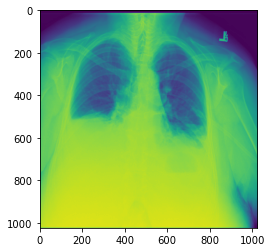

In [39]:
# Image example:

img = mpimg.imread(train_data.iloc[0]['path'])
plt.imshow(img)
plt.show()

### Data Augmentation: random modify contrast (custom function)

rnd_contrast_curve examples:


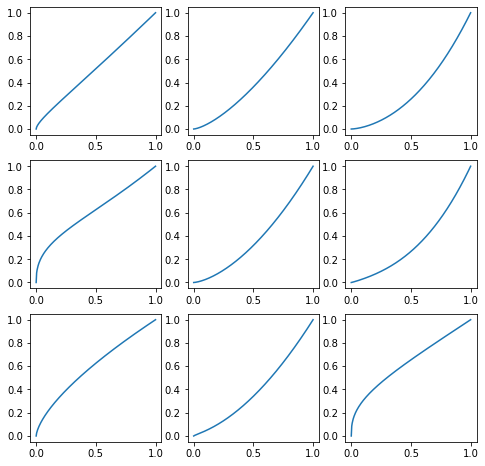

In [40]:
# "homemade" data augmentation: randomize contrast

def rnd_contrast_curve(x):
    # 0 <= x <= 1
    # [ s*x^a + (1-s)*x^b ]
    s = np.random.uniform(0.,1.)
    a = np.random.uniform(0.5,3.)
    b = 1. / np.random.uniform(0.5,3.)
    return s*np.power(x, a) + (1.-s)*np.power(x,b)

x = np.linspace(0.,1.,256)

print("rnd_contrast_curve examples:")
fig, axs = plt.subplots(3, 3, figsize = (8, 8))
for ax in axs.flatten():
    ax.plot(x, rnd_contrast_curve(x))

plt.show()

rnd_contrast_curve applied to img (rnd_modify_contrast):


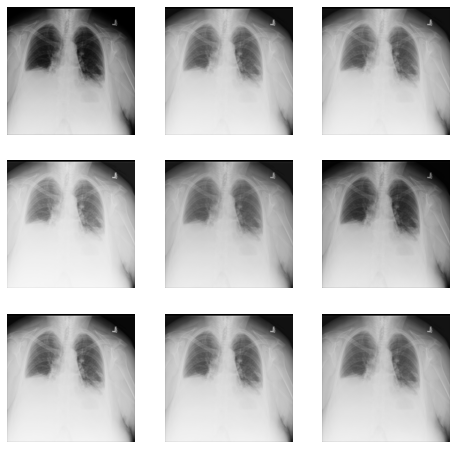

In [42]:
def normalize_img(img):
    if np.max(img)>1:
        img = img / 255.
    return img

def rnd_modify_contrast(img):
    '''Randomly modify contrast to image'''
    # 0 <= x <= 1
    # [ s*x^a + (1-s)*x^b ]
    max_img = np.max(img)
    pil_img = Image.fromarray(np.uint8(img/max_img*255)).convert("RGB")
    s = np.random.uniform(0.,1.)
    a = np.random.uniform(0.5,3.0)
    b = 1. / np.random.uniform(0.5,3.0)
    new_img = np.array(pil_img.point(lambda x: 255.*(s*((x/255.)**a) + (1.-s)*((x/255.)**b)))) # *max_img.astype('uint8') # /255.
    return normalize_img(new_img)

print("rnd_contrast_curve applied to img (rnd_modify_contrast):")
fig, axs = plt.subplots(3, 3, figsize = (8, 8))
for ax in axs.flatten():
    mod_img = rnd_modify_contrast(img)
    ax.imshow(mod_img, cmap = 'gray')
    ax.axis('off')

plt.show()

steps_per_epoch: 32
Found 2290 validated image filenames belonging to 2 classes.


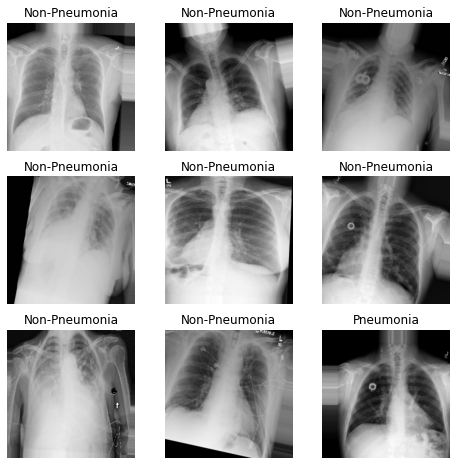

In [16]:
def make_train_gen(train_data, IMG_SIZE=IMG_SIZE):

    # create data generator
    idg = ImageDataGenerator(
        rescale = 1./255.,
        horizontal_flip = True,
        vertical_flip = False,
        height_shift_range = 0.1,
        width_shift_range = 0.1,
        rotation_range = 15., 
        shear_range = 0.05,
        zoom_range = 0.1
        # brightness_range = [0.8,1.1]
        # preprocessing_function = rnd_modify_contrast # normalize_img
    )
    
    # number of batches of samples comprising one epoch
    steps_per_epoch = train_batch_size # int(np.ceil(n_train / train_batch_size))
    print("steps_per_epoch:", steps_per_epoch)
    
    train_gen = idg.flow_from_dataframe(
        dataframe = train_data,
        directory = None,
        x_col = 'path',
        y_col = 'pneumonia_class',
        class_mode = 'binary',
        target_size = IMG_SIZE,
        batch_size = steps_per_epoch
    )
    
    return train_gen

gen_train = make_train_gen(train_data)

t_x, t_y = next(gen_train)

fig, m_axs = plt.subplots(3, 3, figsize = (8, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'gray')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('Non-Pneumonia')
    c_ax.axis('off')
plt.show()

steps_per_epoch: 512
Found 1479 validated image filenames belonging to 2 classes.


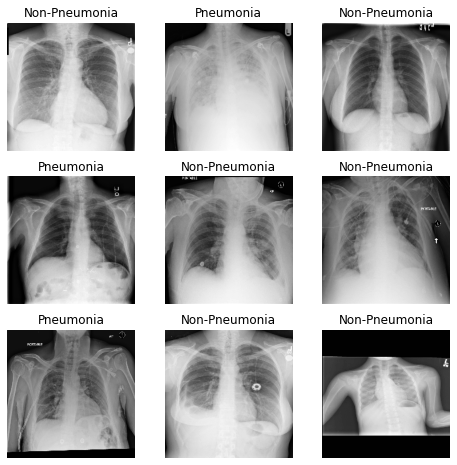

In [17]:
def make_val_gen(val_data, IMG_SIZE=IMG_SIZE):

    # create data generator
    idg = ImageDataGenerator(
        rescale = 1./255.
    ) # rescale only
    
    # number of batches of samples comprising one epoch
    steps_per_epoch = test_batch_size # n_test # int(np.ceil(n_train / train_batch_size))
    print("steps_per_epoch:", steps_per_epoch)
    
    val_gen = idg.flow_from_dataframe(
        dataframe = val_data,
        directory = None,
        x_col = 'path',
        y_col = 'pneumonia_class',
        class_mode = 'binary',
        target_size = IMG_SIZE,
        batch_size = steps_per_epoch
    )
    
    return val_gen

gen_val = make_val_gen(test_data)

v_x, v_y = next(gen_val)
fig, m_axs = plt.subplots(3, 3, figsize = (8, 8))
for (c_x, c_y, c_ax) in zip(v_x, v_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'gray')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('Non-Pneumonia')
    c_ax.axis('off')
plt.show()

In [18]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = gen_val.next()

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [21]:
def load_pretrained_model():
    
    model = ResNet50(include_top = True,
                     weights = 'imagenet',
                     # input_shape=input_shape
                    ) #, input_shape=input_shape) # or VGG16
    #model.summary()
    transfer_layer = model.layers[-2]
    
    transfer_model = Model(inputs = model.input, outputs = transfer_layer.output)
    for layer in transfer_model.layers[:]:
            layer.trainable = False
    
    transfer_model.summary()
    return transfer_model

transfer_model = load_pretrained_model()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [22]:
for layer in transfer_model.layers:
    print(layer.name, layer.trainable)

input_3 False
conv1_pad False
conv1 False
bn_conv1 False
activation_99 False
pool1_pad False
max_pooling2d_3 False
res2a_branch2a False
bn2a_branch2a False
activation_100 False
res2a_branch2b False
bn2a_branch2b False
activation_101 False
res2a_branch2c False
res2a_branch1 False
bn2a_branch2c False
bn2a_branch1 False
add_33 False
activation_102 False
res2b_branch2a False
bn2b_branch2a False
activation_103 False
res2b_branch2b False
bn2b_branch2b False
activation_104 False
res2b_branch2c False
bn2b_branch2c False
add_34 False
activation_105 False
res2c_branch2a False
bn2c_branch2a False
activation_106 False
res2c_branch2b False
bn2c_branch2b False
activation_107 False
res2c_branch2c False
bn2c_branch2c False
add_35 False
activation_108 False
res3a_branch2a False
bn3a_branch2a False
activation_109 False
res3a_branch2b False
bn3a_branch2b False
activation_110 False
res3a_branch2c False
res3a_branch1 False
bn3a_branch2c False
bn3a_branch1 False
add_36 False
activation_111 False
res3b_branc

In [23]:
def build_my_model(transfer_model, new_layers):
    
    model = Sequential()
    model.add(transfer_model)
    for layer in new_layers:
        model.add(layer)
    
    optimizer = Adam(lr=1e-4) #, beta_1=0.97, beta_2=0.998, epsilon=1e-08, decay=0.0005)
    #optimizer = SGD(lr=0.0002, decay=1e-6, momentum=0.9, nesterov=True)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy', f1] # Precision(), Recall(), TruePositives(), FalsePositives()]
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

new_layers = [
    # Flatten(), # Flatten the output of the model because it is from a convolutional layer.
    # GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1024, activation='relu'),# kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') # relu
]

model = build_my_model(transfer_model=transfer_model, new_layers=new_layers)
model.summary()

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 2048)              23587712  
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

## Define Check-Points

In [26]:
# weight_path = "valAcc_{val_accuracy:.3f}__epoch_{epoch:02d}__model.best.hdf5"
weight_path = "xray_class_model.best"

# Save weights if val_accuracy grows
checkpoint = ModelCheckpoint(weight_path,
                             monitor = 'val_loss', 
                             mode = 'min',
                             verbose = 1,
                             save_best_only = True, 
                             save_weights_only = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              patience=1,
                              mode = 'min',
                              factor=0.2,
                              min_lr=5e-6,
                              verbose=1,
                              min_delta=0.01, 
                              cooldown=2)

# EarlyStopping: avoid overfitting
early = EarlyStopping(monitor = 'val_loss',
                      mode = 'min',
                      patience = 10)

callbacks_list = [checkpoint, early]

In [27]:
print("train_batch_size:", train_batch_size)
print("test_batch_size:",  test_batch_size)

train_batch_size: 32
test_batch_size: 512


### Start training! 

In [28]:
## train your model

history = model.fit_generator(gen_train,
                              validation_data = gen_val,
                              # validation_steps = n_test / test_batch_size,
                              epochs = 35,
                              callbacks = callbacks_list)

Epoch 1/35
72/72 [==============================] - 98s 1s/step - loss: 1.0004 - binary_accuracy: 0.5109 - f1: 0.5030 - val_loss: 0.8094 - val_binary_accuracy: 0.1934 - val_f1: 0.3233

Epoch 00001: val_loss improved from inf to 0.80939, saving model to xray_class_model.best
Epoch 2/35
72/72 [==============================] - 68s 943ms/step - loss: 0.9114 - binary_accuracy: 0.5144 - f1: 0.5190 - val_loss: 0.7213 - val_binary_accuracy: 0.1934 - val_f1: 0.3240

Epoch 00002: val_loss improved from 0.80939 to 0.72126, saving model to xray_class_model.best
Epoch 3/35
72/72 [==============================] - 68s 944ms/step - loss: 0.8706 - binary_accuracy: 0.5271 - f1: 0.5146 - val_loss: 0.9312 - val_binary_accuracy: 0.1934 - val_f1: 0.3233

Epoch 00003: val_loss did not improve from 0.72126
Epoch 4/35
72/72 [==============================] - 67s 935ms/step - loss: 0.8258 - binary_accuracy: 0.5288 - f1: 0.5112 - val_loss: 0.9190 - val_binary_accuracy: 0.1934 - val_f1: 0.3238

Epoch 00004: val

In [29]:
# Export model

import json
model_json = model.to_json()

with open("model_in_json.json", "w") as json_file:
    json.dump(model_json, json_file)

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

dict_keys(['val_loss', 'val_binary_accuracy', 'val_f1', 'loss', 'binary_accuracy', 'f1'])


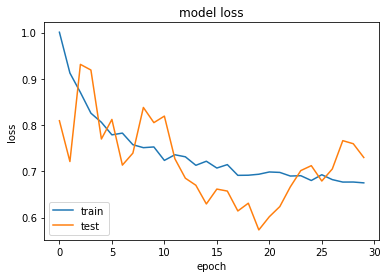

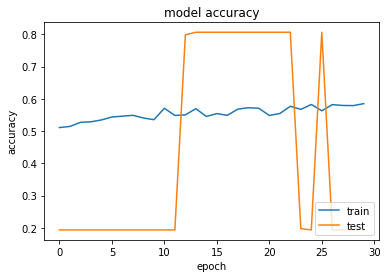

In [30]:
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [31]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.

weight_path = "xray_class_model.best"

with open("model_in_json.json", "r") as f:
    model_json = json.load(f)

model = model_from_json(model_json)
model.load_weights(weight_path)

In [32]:
# pred_Y = model.predict(valX, batch_size = 32, verbose = True)
pred_Y = model.predict(valX, batch_size = test_batch_size, verbose = True)

512/512 [==============================] - 7s 14ms/step


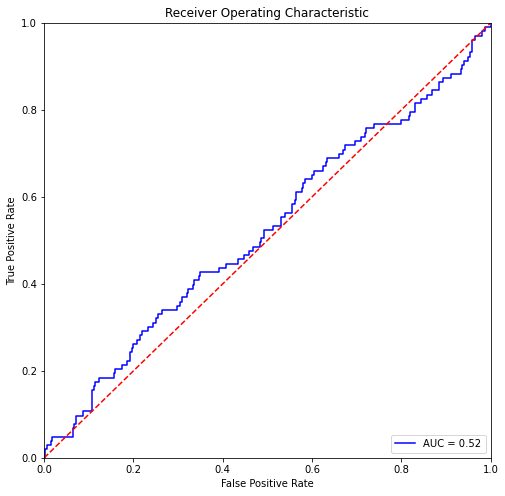

In [33]:
def plot_auc(t_y, p_y):
    
    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = roc_curve(t_y, p_y)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    return

plot_auc(valY, pred_Y)

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    return

In [ ]:
## plot figures

# Todo

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)